In [1]:
import pandas as pd
import numpy as np
import warnings
from scipy import stats
from IPython.display import display, HTML
from sklearn import metrics as me

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows",20)
pd.set_option('precision', 4)

%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import itertools
#matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          append = "",
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Confusion matrix {}'.format(append)
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive "],
             ["\n False Negative ", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value, scenario):
    from sklearn.metrics import confusion_matrix
    append = '{}; \n Total Normal traffic:{}, \n Total Attack Traffic: {}'.format(scenario, 
                                                                            actual_value.groupby(actual_value).count()[0], 
                                                                           actual_value.groupby(actual_value).count()[1])
    
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False, append = append)


In [3]:
def evaluate_lstm(model, past_scores, predictions):
    return evaluate(model, past_scores, predictions, 'LSTM')

lstm_result = []

def display_and_save(name, plot):
    fig = plot.get_figure()
    fig.savefig("result_plots/{}.eps".format(name.replace(":","").strip()), format='eps', dpi=1000)
    fig.savefig("result_plots/{}.png".format(name.replace(":","").strip()), format='png', dpi=1000)
    display(plot)

def evaluate(model, past_scores, predictions, model_type='AE'):
    all_scenarios = pd.DataFrame(columns=['Model','Scenarios', 'Number of Features', 'Accuracy', 'Quality Score', 'Precision', 'Recall'])

    
    def get_best_df(past_scores):
        psg = past_scores.sort_values(by='quality_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
        df = psg.first().sort_values(by='quality_score', ascending=False)
        return df
    def get_median_df(past_scores):
        psg = past_scores.sort_values(by='quality_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
        df = psg.nth(int(psg.size()[0]/2)).sort_values(by='quality_score', ascending=False)
        return df
    def get_worst_df(past_scores):
        psg = past_scores.sort_values(by='quality_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
        df = psg.last().sort_values(by='quality_score', ascending=False)
        return df
    
    def get_result(past_scores, which='best'):
        if which == 'best':
            df = get_best_df(past_scores)
        elif which == 'median':
            df = get_median_df(past_scores)
        elif which == 'worst':
            df = get_worst_df(past_scores)
            
        #epoch_nof_hidden
        key = int(df.iloc[0]['key'])
        nof = df.iloc[0].name[0]
        hidden = df.iloc[0].name[1]
        
        return "{}_{}_{}".format(key, nof, hidden), nof, df

    def view_data(name, past_scores, which):
        _, _, df = get_result(past_scores, which)
        #display(name)
        #display(df)
        
        group_by = 'no_of_features'
        if(model_type == 'LSTM'):
            group_by = 'hidden_layers'
        df1 = df.reset_index().sort_values(by='quality_score', ascending=False).groupby(by=[group_by])
        
        df1 = df1.first().loc[:,['quality_score', 'time_taken']]
        df1 = df1.rename(index={1:"One", 4:"10%", 8:"20%", 16:"40%", 42:"All"})
        plot = df1.plot(secondary_y = 'time_taken', title=name)#,figsize=(10, 10))
        display_and_save(name, plot)
        
    #display("Individual Results for each Scenario:-")    
    view_data("   Results for {}: Best case".format(model),past_scores, 'best')
    view_data("   Results for {}: General case".format(model),past_scores,'median')
    view_data("   Results for {}: Worst case".format(model),past_scores,'worst')
        
    def get_score(y_true, y_pred):
        f1 = me.matthews_corrcoef(y_true, y_pred)
        pre = me.precision_score(y_true, y_pred)
        rec = me.recall_score(y_true, y_pred)
        acc = me.accuracy_score(y_true, y_pred)
        return {"Quality Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}
    
    display("Combined Results from all Scenarios for {}".format(model))

    
    
    def accumulate_scenarios(predictions, past_scores, which='best'):
        key, nof, df = get_result(past_scores, which)
        y_true = predictions[key]["Actual"]
        y_pred = predictions[key]["Prediction"]
        y_true = y_true.dropna()
        y_pred = y_pred.dropna()
        
        scores = get_score(y_true, y_pred)
        scores.update({"Scenarios":scenario,"Number of Features":nof,"Model":model})
        plot(y_true, y_pred, scenario)
        return pd.DataFrame(scores, index=[1])
    
    scenario = "Best Result"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores, 'best'))
    scenario = "General Result"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores, 'median'))
    scenario = "Worst Result"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores, 'worst'))
    
    
    display(all_scenarios.set_index(['Model','Scenarios','Number of Features']))

    return all_scenarios
    
    
    
    
    

In [4]:
past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")
predictions = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")

'Combined Results from all Scenarios for Fully Connected'

Accuracy  Precision  \
Model           Scenarios      Number of Features                        
Fully Connected Best Result    1                     0.8424     0.9973   
                General Result 1                     0.7098     0.9899   
                Worst Result   1                     0.6815     0.9922   

                                                   Quality Score  Recall  
Model           Scenarios      Number of Features                         
Fully Connected Best Result    1                          0.5448  0.8284  
                General Result 1                          0.1945  0.7069  
                Worst Result   1                          0.0246  0.6838

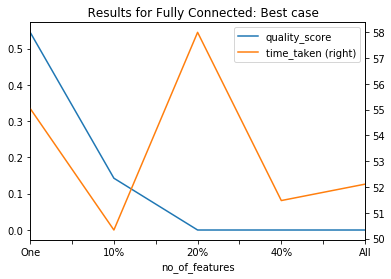

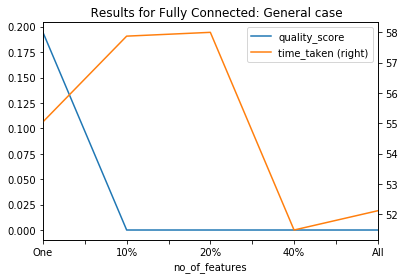

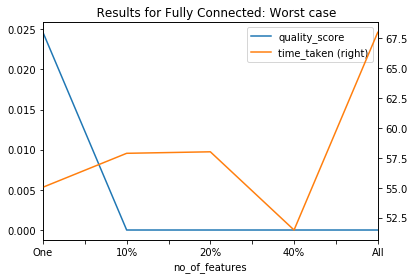

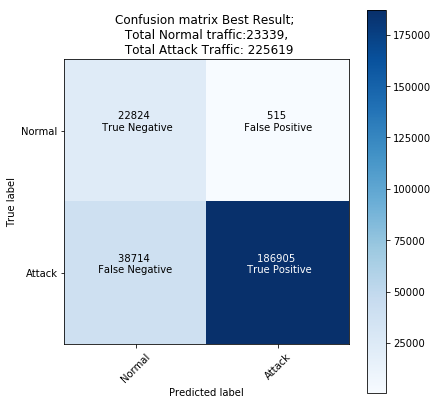

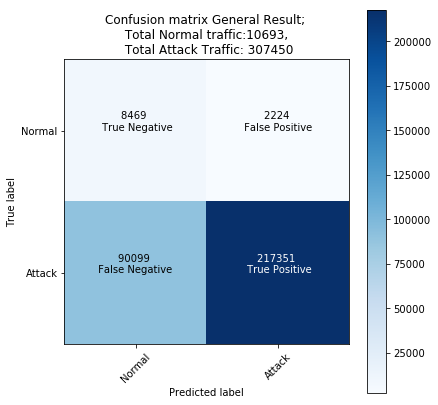

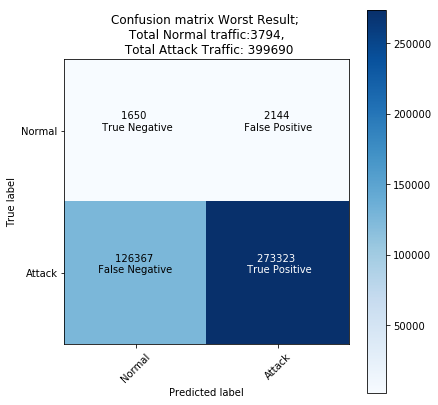

In [5]:
all_scenarios_fcn = evaluate("Fully Connected", past_scores, predictions)

psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
df = psg.first().sort_values(by='f1_score', ascending=False).head(5)
df1 = df.reset_index().sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features'])
df1 = df1.first().loc[:,['f1_score', 'time_taken']]
df1 = df1.rename(index={1:"One", 4:"10%", 8:"20%", 16:"40%", 42:"All"})
df1.plot(secondary_y = 'time_taken', table=True)

In [6]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_scores-all.pkl")
predictions = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")

'Combined Results from all Scenarios for VAE-Softmax'

Accuracy  Precision  \
Model       Scenarios      Number of Features                        
VAE-Softmax Best Result    4                     0.7574     0.7600   
            General Result 4                     0.8853     0.9891   
            Worst Result   42                    0.9723     0.9867   

                                               Quality Score  Recall  
Model       Scenarios      Number of Features                         
VAE-Softmax Best Result    4                          0.3779  0.9468  
            General Result 4                          0.0904  0.8934  
            Worst Result   42                         0.0020  0.9851

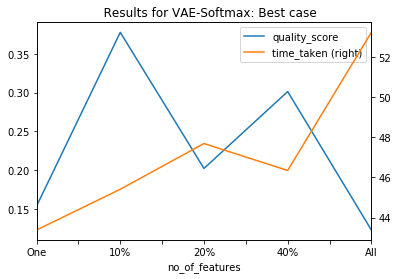

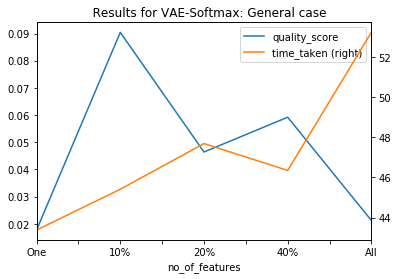

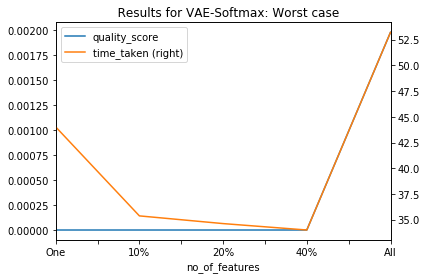

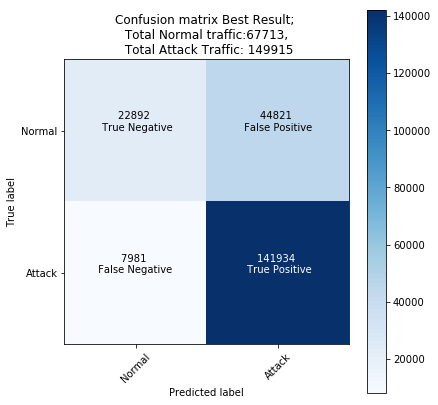

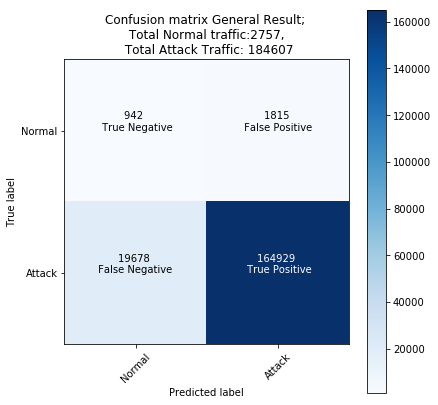

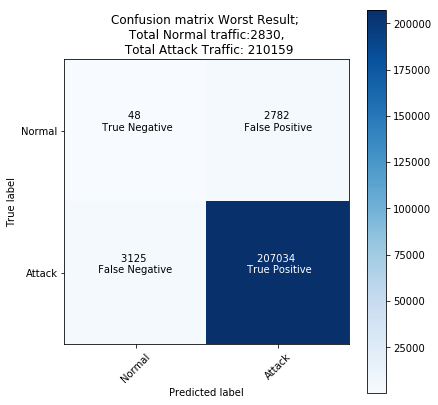

In [7]:
all_scenarios_vae_sm = evaluate("VAE-Softmax", past_scores, predictions)

In [8]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_only_vae_loss_nsl_kdd_scores_all.pkl")
predictions = pd.read_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions.pkl")

'Combined Results from all Scenarios for VAE-LabelGeneration'

Accuracy  Precision  \
Model               Scenarios      Number of Features                        
VAE-LabelGeneration Best Result    1                     0.7419     0.9752   
                    General Result 8                     0.5578     0.9835   
                    Worst Result   1                     0.9834     0.9834   

                                                       Quality Score  Recall  
Model               Scenarios      Number of Features                         
VAE-LabelGeneration Best Result    1                          0.0564  0.7530  
                    General Result 8                          0.0057  0.5595  
                    Worst Result   1                          0.0000  1.0000

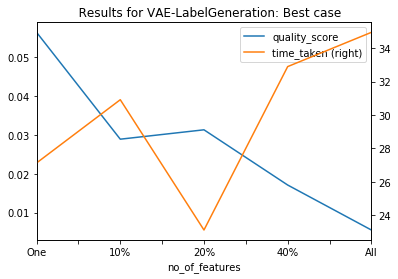

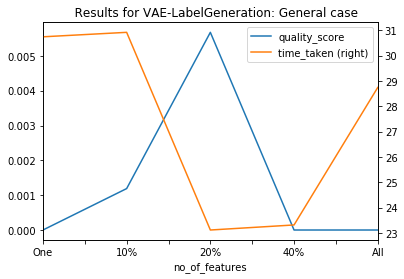

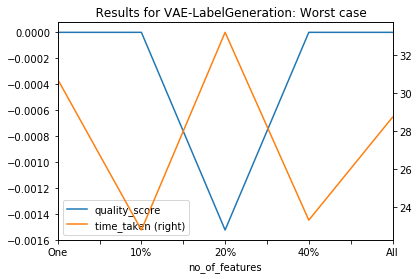

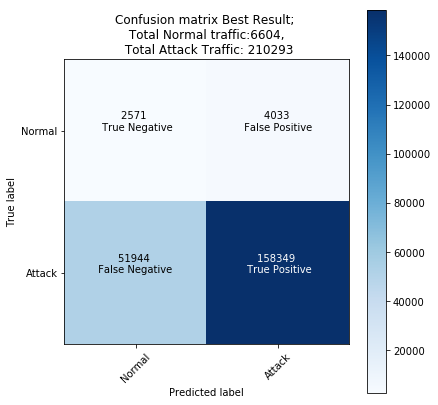

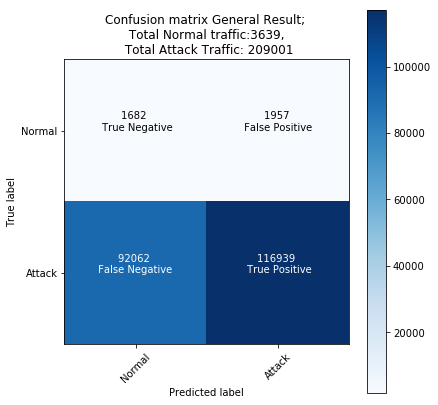

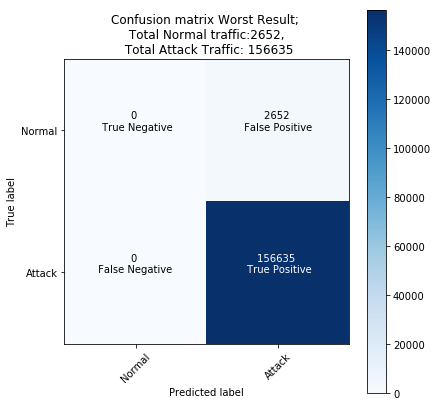

In [9]:
all_scenarios_vae = evaluate("VAE-LabelGeneration", past_scores, predictions)

In [10]:
past_scores = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl")
predictions = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions.pkl")

'Combined Results from all Scenarios for LSTM Seq2Seq'

Accuracy  Precision  \
Model        Scenarios      Number of Features                        
LSTM Seq2Seq Best Result    1                        1.0        1.0   
             General Result 1                        1.0        1.0   
             Worst Result   1                        1.0        1.0   

                                                Quality Score  Recall  
Model        Scenarios      Number of Features                         
LSTM Seq2Seq Best Result    1                             1.0     1.0  
             General Result 1                             1.0     1.0  
             Worst Result   1                             1.0     1.0

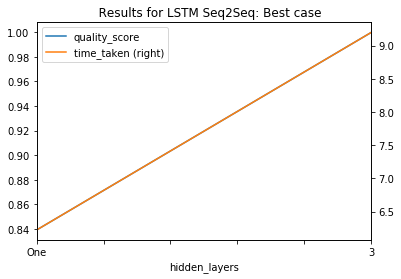

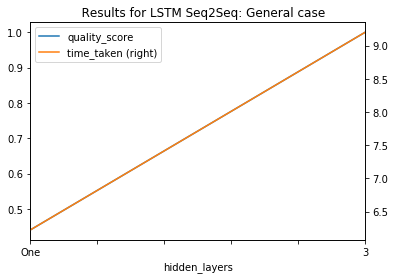

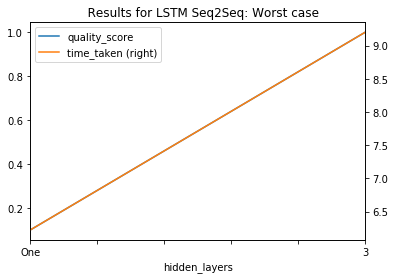

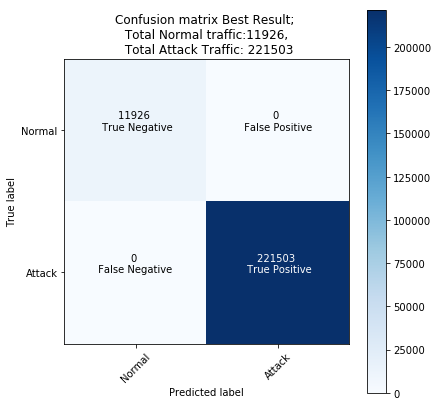

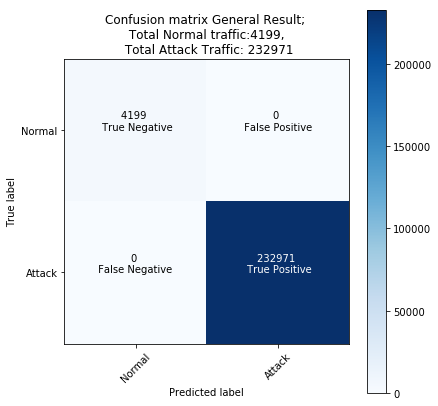

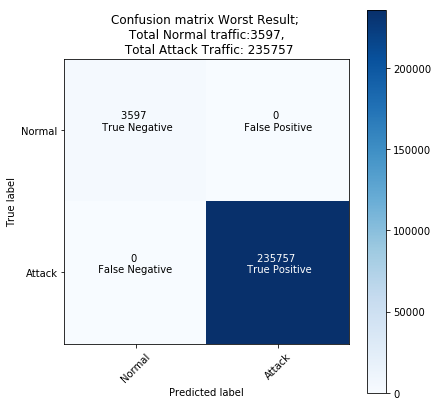

In [11]:
all_scenarios_lstm = evaluate_lstm("LSTM Seq2Seq", past_scores, predictions)

In [12]:
all_scenarios = pd.concat([all_scenarios_fcn, all_scenarios_vae_sm, all_scenarios_vae, all_scenarios_lstm],axis=0)

In [13]:
all_scenarios_display = all_scenarios.set_index(['Model', 'Scenarios', 'Number of Features'])
#all_scenarios_display

In [14]:
all_scenarios_best = all_scenarios.set_index(['Scenarios', 'Model']) #, 'Number of Features'
all_scenarios_best.loc['Best Result']


,Accuracy,Number of Features,Precision,Quality Score,Recall
Model,,,,,
Fully Connected,0.8424,1,0.9973,0.5448,0.8284
VAE-Softmax,0.7574,4,0.7600,0.3779,0.9468
VAE-LabelGeneration,0.7419,1,0.9752,0.0564,0.7530
LSTM Seq2Seq,1.0000,1,1.0000,1.0000,1.0000


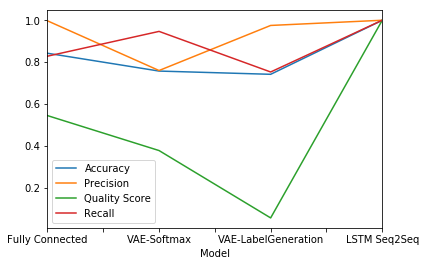

In [15]:
plot = all_scenarios_best.loc['Best Result'].drop('Number of Features', axis = 1).plot()
display_and_save("all_models_score_best_result", plot)

In [16]:
all_scenarios_best.loc['General Result']

,Accuracy,Number of Features,Precision,Quality Score,Recall
Model,,,,,
Fully Connected,0.7098,1,0.9899,0.1945,0.7069
VAE-Softmax,0.8853,4,0.9891,0.0904,0.8934
VAE-LabelGeneration,0.5578,8,0.9835,0.0057,0.5595
LSTM Seq2Seq,1.0000,1,1.0000,1.0000,1.0000


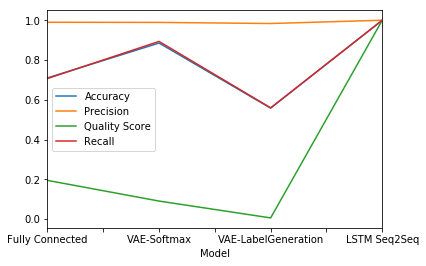

In [17]:
plot = all_scenarios_best.loc['General Result'].drop('Number of Features', axis = 1).plot()
display_and_save("all_models_score_general_result", plot)

In [18]:
all_scenarios_best.loc['Worst Result']

,Accuracy,Number of Features,Precision,Quality Score,Recall
Model,,,,,
Fully Connected,0.6815,1,0.9922,0.0246,0.6838
VAE-Softmax,0.9723,42,0.9867,0.0020,0.9851
VAE-LabelGeneration,0.9834,1,0.9834,0.0000,1.0000
LSTM Seq2Seq,1.0000,1,1.0000,1.0000,1.0000


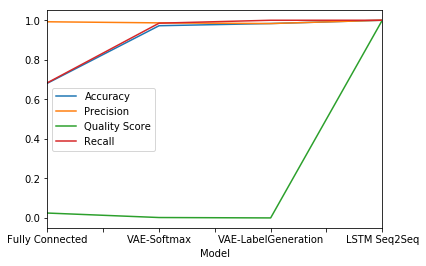

In [19]:
plot = all_scenarios_best.loc['Worst Result'].drop('Number of Features', axis = 1).plot()
display_and_save("all_models_score_worst_result", plot)

In [20]:
%%bash
zip -r result_plots.zip result_plots

updating: result_plots/ (stored 0%)
updating: result_plots/Results for LSTM Seq2Seq General case.png (deflated 25%)
updating: result_plots/all_models_score_general_result.png (deflated 22%)
updating: result_plots/all_models_score_best_result.png (deflated 21%)
updating: result_plots/all_models_score_worst_result.png (deflated 25%)
updating: result_plots/Results for VAE-LabelGeneration Worst case.png (deflated 17%)
updating: result_plots/Results for LSTM Seq2Seq Best case.png (deflated 24%)
updating: result_plots/Results for VAE-LabelGeneration General case.png (deflated 18%)
updating: result_plots/Results for VAE-Softmax General case.png (deflated 18%)
updating: result_plots/Results for Fully Connected General case.png (deflated 21%)
updating: result_plots/Results for LSTM Seq2Seq Worst case.png (deflated 26%)
updating: result_plots/Results for VAE-Softmax Worst case.png (deflated 22%)
updating: result_plots/Results for Fully Connected Worst case.png (deflated 21%)
updating: result_plo